## 1. Data Ingestion and Serialization (ETL)

This section implements the initial **Extract, Transform, Load (ETL)** pipeline to prepare the raw CCMatrix dataset for high-performance processing.

**Key Objectives:**
* **Extraction**: Stream raw text data from `.en` and `.vi` source files line-by-line to avoid memory overload.
* **Transformation**: Standardize data into a structured schema (ID + Translation Pair).
* **Loading**: Serialize the processed data into **Apache Arrow** format (via Hugging Face `datasets`) for efficient memory-mapped access in subsequent stages.

### 1.1. Environment Setup and Configurations

In [1]:
import os
import time
import logging
from pathlib import Path
from datasets import Dataset, Features, Value

In [2]:
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)

In [3]:
raw_data_path: str = (
    r"C:\Users\LONG\Computer Science\Artificial Intelligence\Projects\Attention-Is-All-You-Build\data\en-vi.txt"
)

In [4]:
# --- Configurations ---
# TODO: Update these paths to match your local environment.
# RAW_DATA_DIR = Path("./raw_data")
RAW_DATA_DIR = Path(raw_data_path)
EN_FILE_PATH = RAW_DATA_DIR / "CCMatrix.en-vi.en"
VI_FILE_PATH = RAW_DATA_DIR / "CCMatrix.en-vi.vi"

PROCESSED_DATA_DIR = Path("./processed_data")
ARROW_OUTPUT_PATH = PROCESSED_DATA_DIR / "ccmatrix_arrow_raw"

In [5]:
# Ensure output directory exists
PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)

logger.info(f"Configured raw English path: {EN_FILE_PATH}")
logger.info(f"Configured raw Vietnamese path: {VI_FILE_PATH}")
logger.info(f"Configured output path: {ARROW_OUTPUT_PATH}")

2025-11-09 11:50:57,806 - INFO - Configured raw English path: C:\Users\LONG\Computer Science\Artificial Intelligence\Projects\Attention-Is-All-You-Build\data\en-vi.txt\CCMatrix.en-vi.en
2025-11-09 11:50:57,808 - INFO - Configured raw Vietnamese path: C:\Users\LONG\Computer Science\Artificial Intelligence\Projects\Attention-Is-All-You-Build\data\en-vi.txt\CCMatrix.en-vi.vi
2025-11-09 11:50:57,809 - INFO - Configured output path: processed_data\ccmatrix_arrow_raw


### 1.2. Streaming Ingestion Pipeline

In [6]:
def raw_text_generator(en_path: Path, vi_path: Path):
    """
    Generator function to stream raw text files line-by-line.

    Why use this?
    - Avoids loading the entire 50M+ sentence dataset into RAM at once (OOM risk).
    - Allows Hugging Face 'datasets' to perform streaming conversion to Arrow format.
    """
    with open(en_path, "r", encoding="utf-8") as f_en, open(
        vi_path, "r", encoding="utf-8"
    ) as f_vi:
        # Using enumerate to provide a stable, reproducible ID for each pair.
        for idx, (line_en, line_vi) in enumerate(zip(f_en, f_vi)):
            yield {
                "id": idx,
                "translation": {"en": line_en.strip(), "vi": line_vi.strip()},
            }

In [7]:
# --- Define Explicit Schema ---
# Explicitly defining features ensures type safety and optimized storage in Arrow.
CCMATRIX_FEATURES = Features(
    {
        "id": Value("int64"),
        "translation": {"en": Value("string"), "vi": Value("string")},
    }
)

In [8]:
# --- Execution of the ETL Pipeline ---
if not ARROW_OUTPUT_PATH.exists():
    logger.info("Arrow dataset not found. Starting ingestion pipeline...")
    start_time = time.time()

    # 'from_generator' handles the heavy lifting of streaming and writing to disk simultaneously.
    raw_dataset = Dataset.from_generator(
        raw_text_generator,
        gen_kwargs={"en_path": EN_FILE_PATH, "vi_path": VI_FILE_PATH},
        features=CCMATRIX_FEATURES,
    )

    logger.info(
        f"Ingestion complete. Saving to disk at standard Arrow format: {ARROW_OUTPUT_PATH}"
    )
    # save_to_disk() performs the final serialization, enabling memory-mapped loading later.
    raw_dataset.save_to_disk(str(ARROW_OUTPUT_PATH))

    duration = (time.time() - start_time) / 60
    logger.info(f"ETL pipeline finished in {duration:.2f} minutes.")
else:
    logger.info(
        f"Dataset already exists at {ARROW_OUTPUT_PATH}. Skipping ingestion to save time."
    )

2025-11-09 11:51:06,533 - INFO - Dataset already exists at processed_data\ccmatrix_arrow_raw. Skipping ingestion to save time.


## 2. Exploratory Data Analysis (EDA)

This section performs an initial inspection of the raw dataset to understand its basic characteristics and identify potential noise patterns before cleaning.

**Key Objectives:**
* **Sanity Check**: Verify dataset size and structure after ingestion to ensure data integrity.
* **Qualitative Inspection**: Randomly sample sentence pairs to manually assess translation quality and identify common noise types (e.g., misalignment, encoding errors).
* **Quantitative Analysis**: Calculate and visualize basic statistics, focusing on sentence length distributions, to inform data filtering thresholds in the subsequent cleaning stage.

### 2.1. Loading and Basic Inspection
#### Load Dataset & Print Info

In [9]:
from datasets import load_from_disk
import numpy as np

In [10]:
try:
    # Load the memory-mapped dataset from the previous step
    raw_dataset = load_from_disk(str(ARROW_OUTPUT_PATH))
    logger.info(f"Successfully loaded dataset from {ARROW_OUTPUT_PATH}")
    logger.info(f"Total sentence pairs: {len(raw_dataset):,}")
    print("\nDataset Schema:\n", raw_dataset)
except FileNotFoundError:
    logger.error(
        f"Dataset not found at {ARROW_OUTPUT_PATH}. Please execute Section 1 first."
    )

Loading dataset from disk:   0%|          | 0/24 [00:00<?, ?it/s]

2025-11-09 11:51:16,589 - INFO - Successfully loaded dataset from processed_data\ccmatrix_arrow_raw
2025-11-09 11:51:16,590 - INFO - Total sentence pairs: 50,092,444



Dataset Schema:
 Dataset({
    features: ['id', 'translation'],
    num_rows: 50092444
})


#### Random Sampling

In [11]:
# Inspect random samples to qualitatively assess data noise.
# Fixed seed ensures the same samples are shown every time for reproducibility in reports.
# np.random.seed(42)
NUM_SAMPLES_TO_INSPECT = 5
random_indices = np.random.randint(0, len(raw_dataset), size=NUM_SAMPLES_TO_INSPECT)

print(f"--- Random Sample Inspection (N={NUM_SAMPLES_TO_INSPECT}) ---")
for i, idx in enumerate(random_indices):
    sample = raw_dataset[int(idx)]
    print(f"\n[Sample {i+1} | Original ID: {sample['id']}]")
    print(f"  EN: {sample['translation']['en']}")
    print(f"  VI: {sample['translation']['vi']}")

--- Random Sample Inspection (N=5) ---

[Sample 1 | Original ID: 30746747]
  EN: 5 Bel Canto by Ann Patchett
  VI: 5.Bel Canto của Ann Patchett

[Sample 2 | Original ID: 38510867]
  EN: It can provide air transportation for people and goods without the need for a runway.
  VI: Nó có thể hoạt động chở người và hàng hóa trên không mà không cần đường chạy.

[Sample 3 | Original ID: 12882566]
  EN: That has led analysts to speculate on whether she would resign earlier.
  VI: Điều này khiến các nhà phân tích suy đoán liệu bà ấy có thể từ chức trước nhiệm kỳ.

[Sample 4 | Original ID: 25738499]
  EN: Very briefly, these are the origin, contents, and goal of good conduct in Buddhism.
  VI: Hết sức ngắn gọn, đây là nguồn gốc, nội dung, và mục tiêu của giới hạnh trong Phật Giáo.

[Sample 5 | Original ID: 25216498]
  EN: Articles Recently Tagged: Oceanwide Holdings
  VI: Tập đoàn: Oceanwide Holdings


In [12]:
raw_dataset.cleanup_cache_files()

24

### 2.2. Sentence Length Analysis
#### Compute Lengths

In [ ]:
def compute_approx_lengths(example):
    """
    Computes approximate lengths (word count based on whitespace).
    Provides a quick proxy for sentence complexity before full tokenization.
    """
    return {
        "len_en": len(example["translation"]["en"].strip().split()),
        "len_vi": len(example["translation"]["vi"].strip().split()),
    }


logger.info("Starting parallel length computation...")
# Utilizing all available CPU cores for faster mapping over 50M+ samples.
raw_dataset_with_len = raw_dataset.map(
    compute_approx_lengths,
    num_proc=os.cpu_count() or 2,
    desc="Computing approximate lengths",
)
logger.info("Length computation finished.")

2025-11-09 11:57:47,809 - INFO - Starting parallel length computation...


Computing approximate lengths (num_proc=8):   0%|          | 0/50092444 [00:00<?, ? examples/s]

In [13]:
raw_dataset_with_len[1000000]

{'id': 1000000,
 'translation': {'en': '“He wants to know who I’m spending all these late nights with.”',
  'vi': '“Anh ấy muốn biết tôi đang ở cùng ai vào tất cả những buổi tối muộn.”'},
 'len_en': 12,
 'len_vi': 16}

#### Visualization & Statistics

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [15]:
# Convert only relevant numerical columns to Pandas for memory-efficient plotting
df_lengths = raw_dataset_with_len.select_columns(["len_en", "len_vi"]).to_pandas()

df_lengths.head()

,len_en,len_vi
0,8,5
1,8,13
2,8,9
3,10,22
4,10,16


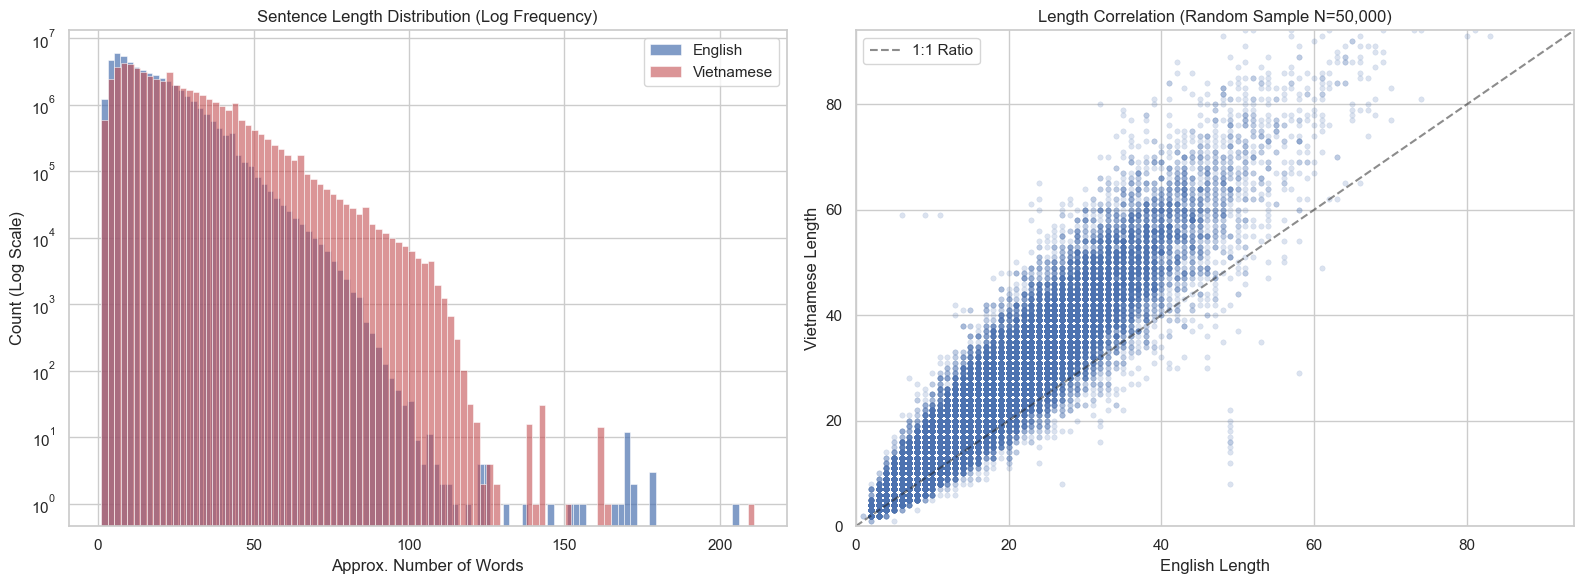

--- Descriptive Statistics for Sentence Lengths ---
           EN Length      VI Length
count  50,092,444.00  50,092,444.00
mean           15.77          21.60
std            10.39          14.74
min             1.00           1.00
25%             8.00          10.00
50%            13.00          18.00
75%            22.00          30.00
max           206.00         211.00


In [16]:
# --- Visualization ---
sns.set_theme(style="whitegrid", context="notebook")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Length Distribution (Log Scale)
# Log scale is crucial here because CCMatrix has a 'long tail' of very rare, extremely long sentences.
sns.histplot(
    df_lengths["len_en"],
    bins=100,
    color="#4C72B0",
    alpha=0.7,
    label="English",
    ax=axes[0],
)
sns.histplot(
    df_lengths["len_vi"],
    bins=100,
    color="#C44E52",
    alpha=0.6,
    label="Vietnamese",
    ax=axes[0],
)

axes[0].set_yscale("log")
axes[0].set_title("Sentence Length Distribution (Log Frequency)")
axes[0].set_xlabel("Approx. Number of Words")
axes[0].set_ylabel("Count (Log Scale)")
axes[0].legend()

# Subplot 2: Length Correlation (Scatter)
# We downsample to 50k points to keep rendering fast and avoid overplotting.
SAMPLE_SIZE = min(50000, len(df_lengths))
df_sample = df_lengths.sample(n=SAMPLE_SIZE, random_state=42)

sns.scatterplot(
    data=df_sample, x="len_en", y="len_vi", alpha=0.2, s=15, edgecolor=None, ax=axes[1]
)
axes[1].set_title(f"Length Correlation (Random Sample N={SAMPLE_SIZE:,})")
axes[1].set_xlabel("English Length")
axes[1].set_ylabel("Vietnamese Length")

# Set sensible limits to focus on the majority of data (e.g., 99th percentile)
max_limit = max(
    df_sample["len_en"].quantile(0.999), df_sample["len_vi"].quantile(0.999)
)
axes[1].set_xlim(0, max_limit)
axes[1].set_ylim(0, max_limit)

axes[1].plot([0, max_limit], [0, max_limit], "k--", alpha=0.5, label="1:1 Ratio")
axes[1].legend()

plt.tight_layout()
plt.show()

# --- Summary Statistics Table ---
print("--- Descriptive Statistics for Sentence Lengths ---")
stats = pd.concat(
    [df_lengths["len_en"].describe(), df_lengths["len_vi"].describe()],
    axis=1,
    keys=["EN Length", "VI Length"],
)
print(stats.map("{:,.2f}".format))

### 2.3. EDA Conclusions & Filtering Strategy

Based on the quantitative and qualitative analysis from the plots in 2.2, we establish the following data-driven filtering strategy for Section 3:

1.  **Length-based Noise**:
    * **Observation**: The histogram shows a massive number of samples with very short lengths (approx. < 3 words) and a long tail of extremely long sentences (approx. > 200 words).
    * **Strategy**: We will set a `MIN_LEN` threshold (e.g., 3 words) to remove fragments and a `MAX_LEN` threshold (e.g., 256 words) to remove concatenated text blocks.

2.  **Alignment-based Noise**:
    * **Observation**: The scatter plot reveals a significant number of outliers far from the 1:1 diagonal, indicating severe misalignment (e.g., `(EN=60, VI=5)`).
    * **Strategy**: We will implement a `MAX_LEN_RATIO` (e.g., 3.0) to discard any pair where one sentence is more than 3x longer than the other (or vice-versa).

This cleaning strategy aims to surgically remove the most obvious noise sources while preserving the high-quality core of the dataset identified in the main cluster of the scatter plot.

## 3. Data Cleaning and Filtering (Optimized)

This section implements an **optimized** filtering pipeline.

**Key Objectives:**
* **Efficiency**: Avoid redundant computations by filtering on pre-computed lengths from Section 2.
* **Cache Control**: Explicitly manage cache file locations to prevent filling the system drive (C:).
* **Noise Removal**: Apply length and ratio filters to the full dataset based on thresholds defined in the EDA.

### 3.1. Defining Filter Functions
#### Configurations & Helper Functions

In [15]:
# --- Filtering Thresholds ---
# These thresholds are empirically chosen based on the EDA in Section 2.
MIN_LEN = 3       # Minimum number of words per sentence (removes fragments like "OK.", "Page 1")
MAX_LEN = 150     # Maximum number of words (removes likely concatenated scraping noise)
MAX_LEN_RATIO = 2.0 # Max allowed ratio between source and target lengths (e.g., 1:4 is invalid)

In [16]:
def is_valid_length_from_cols_batched(examples, min_len, max_len):
    """
    Checks length validity on a batch of examples.
    Returns a boolean mask (list of True/False).
    """
    # Use zip and list comprehension for highly optimized iteration over batches
    return [
        (min_len <= l_en <= max_len) and (min_len <= l_vi <= max_len)
        for l_en, l_vi in zip(examples["len_en"], examples["len_vi"])
    ]


def is_valid_ratio_from_cols_batched(examples, max_ratio):
    """
    Checks length ratio validity on a batch using efficient multiplication.
    Returns a boolean mask (list of True/False).
    """
    return [
        (l_en > 0 and l_vi > 0)
        and (l_en * max_ratio >= l_vi)
        and (l_vi * max_ratio >= l_en)
        for l_en, l_vi in zip(examples["len_en"], examples["len_vi"])
    ]

### 3.2. Applying Filters
#### Execution Pipeline

In [17]:
logger.info(f"Original dataset size: {len(raw_dataset_with_len):,}")

# --- Create kwarg dictionaries to pass to filter functions ---
# These will be passed to each child process
length_kwargs = {"min_len": MIN_LEN, "max_len": MAX_LEN}
ratio_kwargs = {"max_ratio": MAX_LEN_RATIO}

# --- Define explicit cache paths ---
LEN_FILTER_CACHE = PROCESSED_DATA_DIR / "cache" / "cache-len_filter.arrow"
RATIO_FILTER_CACHE = PROCESSED_DATA_DIR / "cache" / "cache-ratio_filter.arrow"

# 1. Apply Length Filter
cleaned_dataset = raw_dataset_with_len.filter(
    is_valid_length_from_cols_batched,
    batched=True,
    batch_size=10000,
    fn_kwargs=length_kwargs,
    num_proc=os.cpu_count(),
    cache_file_name=str(LEN_FILTER_CACHE),
    desc="Filtering by length (batched)",
)
logger.info(f"Size after Length Filter: {len(cleaned_dataset):,}")

# 2. Apply Ratio Filter
cleaned_dataset = cleaned_dataset.filter(
    is_valid_ratio_from_cols_batched,
    batched=True,
    batch_size=10000,
    fn_kwargs=ratio_kwargs,
    num_proc=os.cpu_count(),
    cache_file_name=str(RATIO_FILTER_CACHE),
    desc="Filtering by length ratio (batched)",
)
logger.info(f"Size after Ratio Filter: {len(cleaned_dataset):,}")

# Calculate total removed
removed_count = len(raw_dataset) - len(cleaned_dataset)
removal_percentage = (removed_count / len(raw_dataset)) * 100
logger.info(f"Total removed: {removed_count:,} pairs ({removal_percentage:.2f}%)")

2025-11-07 19:37:12,461 - INFO - Original dataset size: 50,092,444
2025-11-07 19:37:18,462 - INFO - Size after Length Filter: 49,838,747
2025-11-07 19:37:26,573 - INFO - Size after Ratio Filter: 48,563,206
2025-11-07 19:37:26,574 - INFO - Total removed: 1,529,238 pairs (3.05%)


### 3.3. Saving Cleaned Data
#### Persistence

In [22]:
# Save the final cleaned dataset
CLEANED_ARROW_PATH = PROCESSED_DATA_DIR / "ccmatrix_arrow_cleaned"

if not CLEANED_ARROW_PATH.exists():
    logger.info(f"Saving cleaned dataset to {CLEANED_ARROW_PATH}...")
    # We select out the temp length columns as they are no longer needed
    cleaned_dataset_final = cleaned_dataset.select_columns(["id", "translation"])
    cleaned_dataset_final.save_to_disk(str(CLEANED_ARROW_PATH))
    logger.info("Save complete.")
else:
    logger.info(f"Cleaned dataset already exists at {CLEANED_ARROW_PATH}.")

2025-11-06 21:32:49,631 - INFO - Saving cleaned dataset to processed_data\ccmatrix_arrow_cleaned...


Saving the dataset (0/24 shards):   0%|          | 0/49805247 [00:00<?, ? examples/s]

2025-11-06 21:38:17,565 - INFO - Save complete.


## 4. Score-based Enrichment and Filtering

This section implements the primary quality filtering step. We enrich the dataset (already cleaned for length/ratio) with the pre-computed `LASER` scores provided with the original corpus. We then analyze the score distribution and apply a final filter to retain only the highest-quality translation pairs.

**Key Objectives:**
* **Enrichment**: Load the raw scores and merge them into the cleaned dataset using the preserved `id`.
* **Analysis**: Visualize the score distribution to determine a data-driven threshold.
* **Filtering**: Apply the score threshold to create the final, high-quality dataset.

### 4.1. Load Cleaned Data
#### Load Cleaned Dataset

In [18]:
# # Define paths for required datasets
# CLEANED_ARROW_PATH = PROCESSED_DATA_DIR / "ccmatrix_arrow_cleaned"

# try:
#     # Load the dataset filtered by length and ratio (from Section 3)
#     cleaned_dataset = load_from_disk(str(CLEANED_ARROW_PATH))
#     logger.info(
#         f"Successfully loaded 'cleaned_dataset'. Size: {len(cleaned_dataset):,} pairs."
#     )
# except FileNotFoundError:
#     logger.error(
#         f"Cleaned dataset not found at {CLEANED_ARROW_PATH}. Please run Section 3 first."
#     )
# except Exception as e:
#     logger.error(f"Error loading dataset: {e}")

### 4.2. Load and Merge Scores
#### Load Scores File

In [39]:
SCORE_FILE_PATH = RAW_DATA_DIR / "CCMatrix.en-vi.scores"
logger.info(f"Loading scores file from {SCORE_FILE_PATH} into NumPy array...")
try:
    # np.loadtxt is highly optimized for reading text files of numbers
    all_scores_np = np.loadtxt(SCORE_FILE_PATH, dtype=np.float32)
    logger.info(f"Successfully loaded {len(all_scores_np):,} scores into NumPy.")

    if len(all_scores_np) != len(raw_dataset):
        logger.warning(
            f"Score count ({len(all_scores_np):,}) does not match original "
            f"dataset size ({len(raw_dataset):,}). Alignment may be compromised."
        )
except Exception as e:
    logger.error(f"Error loading score file: {e}")

2025-11-07 15:46:31,183 - INFO - Loading scores file from C:\Users\LONG\Computer Science\Artificial Intelligence\Projects\Attention-Is-All-You-Build\data\en-vi.txt\CCMatrix.en-vi.scores into NumPy array...
2025-11-07 15:46:37,652 - INFO - Successfully loaded 50,092,444 scores into NumPy.


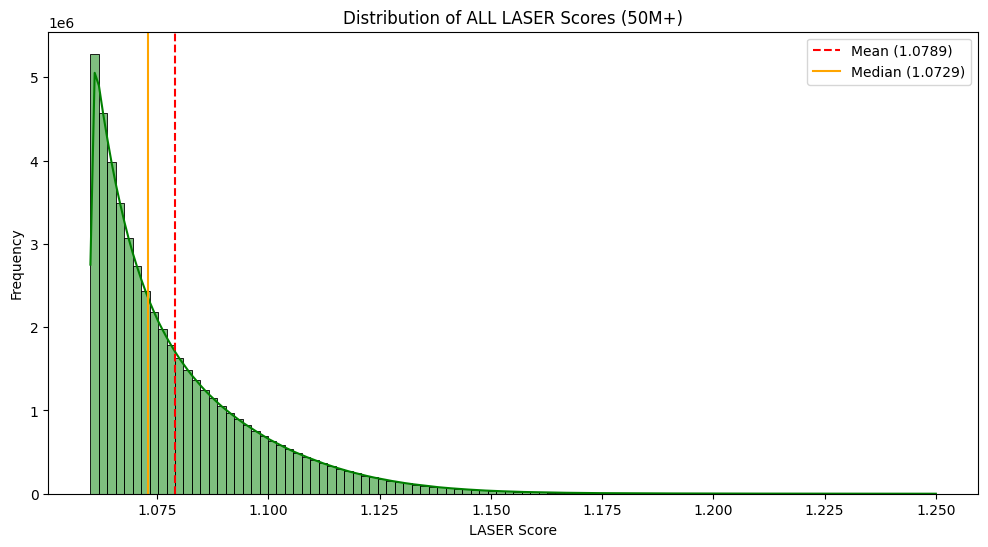


--- Descriptive Statistics for ALL Scores ---
Min:    1.0600
25% (Q1): 1.0650
50% (Med):1.0729
75% (Q3): 1.0872
Max:    1.2500


In [40]:
# --- Analyze Scores (Instantaneous with NumPy) ---
# We can analyze the *entire* 50M score distribution, not just the cleaned one.
plt.figure(figsize=(12, 6))
# Convert to DataFrame just for plotting with Seaborn
sns.histplot(all_scores_np, bins=100, kde=True, color="green")
plt.title("Distribution of ALL LASER Scores (50M+)")
plt.xlabel("LASER Score")
plt.ylabel("Frequency")
mean_score = np.mean(all_scores_np)
median_score = np.median(all_scores_np)
plt.axvline(mean_score, color="red", linestyle="--", label=f"Mean ({mean_score:.4f})")
plt.axvline(
    median_score, color="orange", linestyle="-", label=f"Median ({median_score:.4f})"
)
plt.legend()
plt.show()

# --- Print Summary Statistics ---
print("\n--- Descriptive Statistics for ALL Scores ---")
# Use NumPy's built-in percentile functions
print(f"Min:    {np.min(all_scores_np):.4f}")
print(f"25% (Q1): {np.percentile(all_scores_np, 25):.4f}")
print(f"50% (Med):{np.percentile(all_scores_np, 50):.4f}")
print(f"75% (Q3): {np.percentile(all_scores_np, 75):.4f}")
print(f"Max:    {np.max(all_scores_np):.4f}")

In [41]:
# --- Define Score Threshold ---
# TODO: UPDATE THIS VALUE based on your plot analysis.
# Example: If Q1 (25%) is 1.085, let's use that.
SCORE_THRESHOLD = 1.0872

In [42]:
# --- Get all IDs that pass the score threshold ---
logger.info(f"Identifying all IDs with score > {SCORE_THRESHOLD}...")
# This is a vectorized operation and will be almost instantaneous.
good_ids_np = np.where(all_scores_np > SCORE_THRESHOLD)[0]
logger.info(f"Found {len(good_ids_np):,} IDs matching the score criteria.")

# --- Convert to a Python Set for fast filtering ---
# 'set' provides O(1) lookup speed (instantaneous check)
good_ids_set = set(good_ids_np)
logger.info("Converted 'good' IDs to a set for fast lookup.")

2025-11-07 15:49:30,324 - INFO - Identifying all IDs with score > 1.0872...
2025-11-07 15:49:30,400 - INFO - Found 12,498,561 IDs matching the score criteria.
2025-11-07 15:49:31,446 - INFO - Converted 'good' IDs to a set for fast lookup.


In [43]:
def filter_by_good_ids_batched(examples, good_ids):
    """
    Checks if the IDs in the batch are present in the 'good_ids' set.
    """
    return [id_ in good_ids for id_ in examples["id"]]

In [ ]:
logger.info("Starting final filter (batched) to keep only 'good' IDs...")


# Define explicit cache path
FINAL_FILTER_CACHE_BATCHED = (
    PROCESSED_DATA_DIR / "cache" / "cache-final_filter_batched.arrow"
)

final_dataset = cleaned_dataset.filter(
    filter_by_good_ids_batched,
    batched=True,
    batch_size=10000,  # Can use a larger batch size now, as logic is very light
    fn_kwargs={"good_ids": good_ids_set},  # Pass the 'set'
    num_proc=os.cpu_count(),
    cache_file_name=str(FINAL_FILTER_CACHE_BATCHED),
    desc="Final filtering by ID",
)

# --- Final Report ---
final_count = len(final_dataset)
original_count = len(raw_dataset)
final_percentage = (final_count / original_count) * 100

logger.info(f"--- Pipeline Complete ---")
logger.info(f"Original size: {original_count:,} pairs")
logger.info(f"Final high-quality size: {final_count:,} pairs")
logger.info(f"Retained: {final_percentage:.2f}% of original data (High Quality)")

## 5. Filter Length, Length Ratio, Score

In [13]:
# --- Define Paths ---
# Ensure the processed_data/cache directory exists
CACHE_DIR = PROCESSED_DATA_DIR / "cache"
CACHE_DIR.mkdir(parents=True, exist_ok=True)

LEN_WITH_ARROW_PATH = PROCESSED_DATA_DIR / "ccmatrix_arrow_with_len"
SCORE_FILE_PATH = RAW_DATA_DIR / "CCMatrix.en-vi.scores"
FINAL_FILTER_CACHE = CACHE_DIR / "cache-final_vectorized_filter.arrow"
FINAL_DATASET_PATH = PROCESSED_DATA_DIR / "ccmatrix_arrow_final"

In [ ]:
# --- 1. Load Dataset with Lengths ---
try:
    raw_dataset_with_len = load_from_disk(str(LEN_WITH_ARROW_PATH))
    logger.info(f"Loaded dataset with lengths. Size: {len(raw_dataset_with_len):,}")
except FileNotFoundError:
    logger.error(
        f"Dataset with lengths not found at {LEN_WITH_ARROW_PATH}. Please run Section 2.2 first."
    )

In [21]:
# --- 2. Load Scores into NumPy ---
try:
    logger.info("Loading scores into NumPy array...")
    all_scores_np = np.loadtxt(SCORE_FILE_PATH, dtype=np.float32)
    logger.info(f"Loaded {len(all_scores_np):,} scores.")
except FileNotFoundError:
    logger.error(f"Score file not found at {SCORE_FILE_PATH}.")

2025-11-07 19:38:25,496 - INFO - Loading scores into NumPy array...
2025-11-07 19:38:32,631 - INFO - Loaded 50,092,444 scores.


In [22]:
# --- Define All Thresholds ---
MIN_LEN = 3
MAX_LEN = 150
MAX_LEN_RATIO = 2.0
# We use the 75th percentile (Q3) for the score threshold
SCORE_THRESHOLD = 1.0872

In [23]:
# --- Get Lengths as NumPy Arrays (The Correct Way) ---
# We accept that [:] loads the data as a Python list (which takes time)
# and then we explicitly convert that list into a NumPy array.
logger.info("Extracting length columns (this loads data into RAM as a list)...")
start_time = time.time()
try:
    # Step 1: Load 50M items into a Python list (this is the 70s step)
    len_en_list = raw_dataset_with_len["len_en"][:]
    len_vi_list = raw_dataset_with_len["len_vi"][:]
    logger.info(f"Extracted to lists in {time.time() - start_time:.2f}s")

    # Step 2: Convert lists to NumPy arrays (this is fast)
    logger.info("Converting lists to NumPy arrays...")
    len_en_np = np.array(len_en_list, dtype=np.int32)
    len_vi_np = np.array(len_vi_list, dtype=np.int32)

    # Free up memory from the large lists
    del len_en_list
    del len_vi_list

    logger.info("Conversion to NumPy complete.")

    # Sanity check (this will pass now)
    assert isinstance(len_en_np, np.ndarray), "Failed: len_en_np is not a NumPy array"

except Exception as e:
    logger.error(f"Failed to extract columns. Error: {e}")

2025-11-07 19:38:35,294 - INFO - Extracting length columns (this loads data into RAM as a list)...
2025-11-07 19:39:55,804 - INFO - Extracted to lists in 80.51s
2025-11-07 19:39:55,805 - INFO - Converting lists to NumPy arrays...
2025-11-07 19:39:59,082 - INFO - Conversion to NumPy complete.


In [24]:
logger.info("Computing filter masks (vectorized)...")
start_time = time.time()

# --- 1. Length Mask ---
# (50M ops)
mask_len_en = (len_en_np >= MIN_LEN) & (len_en_np <= MAX_LEN)
# (50M ops)
mask_len_vi = (len_vi_np >= MIN_LEN) & (len_vi_np <= MAX_LEN)
# (50M ops)
mask_length = mask_len_en & mask_len_vi
logger.info(f"Length mask complete. Kept: {np.sum(mask_length):,}")

# --- 2. Ratio Mask (Optimized with Multiplication) ---
# Ensure we avoid division by zero (although mask_length should handle it)
mask_zero = (len_en_np > 0) & (len_vi_np > 0)
# (50M ops * 2)
mask_ratio = (len_en_np * MAX_LEN_RATIO >= len_vi_np) & (
    len_vi_np * MAX_LEN_RATIO >= len_en_np
)
logger.info(f"Ratio mask complete. Kept: {np.sum(mask_ratio):,}")

# --- 3. Score Mask ---
# (50M ops)
mask_score = all_scores_np > SCORE_THRESHOLD
logger.info(f"Score mask complete. Kept: {np.sum(mask_score):,}")

# --- 4. Combine All Masks ---
# (50M ops * 3)
final_mask = mask_length & mask_ratio & mask_zero & mask_score

logger.info(f"All masks computed in {time.time() - start_time:.2f}s")
final_keep_count = np.sum(final_mask)
final_remove_count = len(raw_dataset) - final_keep_count
logger.info(f"Final mask ready. Total to keep: {final_keep_count:,}")
logger.info(
    f"Total to remove: {final_remove_count:,} ({final_remove_count/len(raw_dataset)*100:.2f}%)"
)

2025-11-07 19:39:59,111 - INFO - Computing filter masks (vectorized)...
2025-11-07 19:39:59,312 - INFO - Length mask complete. Kept: 49,838,747
2025-11-07 19:39:59,886 - INFO - Ratio mask complete. Kept: 48,788,765
2025-11-07 19:39:59,964 - INFO - Score mask complete. Kept: 12,498,561
2025-11-07 19:40:00,016 - INFO - All masks computed in 0.90s
2025-11-07 19:40:00,057 - INFO - Final mask ready. Total to keep: 12,276,382
2025-11-07 19:40:00,058 - INFO - Total to remove: 37,816,062 (75.49%)


In [25]:
logger.info("Adding final mask column to dataset...")

# Add the mask as a new column. This is fast.
# We must use 'add_item' as 'add_column' doesn't support NumPy arrays directly
# A slightly safer way is to save/reload, or use from_dict
# Let's use the simplest, most robust method: add_column with a list
final_dataset_with_mask = raw_dataset_with_len.add_column(
    "keep_mask", final_mask.tolist()
)

logger.info("Mask column added.")

2025-11-07 19:40:00,075 - INFO - Adding final mask column to dataset...
2025-11-07 19:41:19,986 - INFO - Mask column added.


In [28]:
logger.info("Starting final filter (batched, single-pass)...")

# This filter is now extremely simple and fast.
# It doesn't need fn_kwargs, so no serialization bottleneck!
final_dataset = final_dataset_with_mask.filter(
    lambda example: example["keep_mask"],  # Keep if True
    batched=True,
    batch_size=10000,
    num_proc=os.cpu_count(),
    cache_file_name=str(FINAL_FILTER_CACHE),
    desc="Applying final mask",
)

# --- Final Report ---
logger.info(f"--- Pipeline Complete ---")
logger.info(f"Original size: {len(raw_dataset):,} pairs")
logger.info(f"Final high-quality size: {len(final_dataset):,} pairs")
logger.info(
    f"Retained: {len(final_dataset) / len(raw_dataset) * 100:.2f}% of original data"
)

2025-11-07 19:41:30,478 - INFO - Starting final filter (batched, single-pass)...
2025-11-07 19:41:31,602 - INFO - --- Pipeline Complete ---
2025-11-07 19:41:31,609 - INFO - Original size: 50,092,444 pairs
2025-11-07 19:41:31,611 - INFO - Final high-quality size: 12,276,382 pairs
2025-11-07 19:41:31,612 - INFO - Retained: 24.51% of original data


In [29]:
final_dataset[0]

{'id': 0,
 'translation': {'en': "That is God's design. that is God's desire.",
  'vi': 'Đơngiản, đó là ý Chúa.'},
 'len_en': 8,
 'len_vi': 5,
 'keep_mask': True}

In [57]:
logger.info(f"Saving final dataset to {FINAL_DATASET_PATH}...")
# Select final columns (we don't need 'id', 'len' or 'mask' for training)
final_dataset_for_training = final_dataset.select_columns(["translation"])

# Overwrite if exists, as this is the definitive final dataset
if FINAL_DATASET_PATH.exists():
    logger.warning(f"Overwriting existing final dataset at {FINAL_DATASET_PATH}")

final_dataset_for_training.save_to_disk(str(FINAL_DATASET_PATH))
logger.info(f"Save complete. Data is ready for Section 6 (Tokenization).")

2025-11-07 20:26:12,217 - INFO - Saving final dataset to processed_data\ccmatrix_arrow_final...
2025-11-07 20:26:12,742 - WARNING - Overwriting existing final dataset at processed_data\ccmatrix_arrow_final


Saving the dataset (0/6 shards):   0%|          | 0/12276382 [00:00<?, ? examples/s]

2025-11-07 20:27:47,523 - INFO - Save complete. Data is ready for Section 6 (Tokenization).


## 6. Load Final Dataset

In [14]:
# Load the dataset that passed all filters (Length, Ratio, Score)
# This is the 12.3M subset.
try:
    final_dataset = load_from_disk(str(FINAL_DATASET_PATH))
    logger.info(f"Loaded 'final_dataset' with {len(final_dataset):,} pairs.")
except FileNotFoundError:
    logger.error(
        f"Final dataset not found at {FINAL_DATASET_PATH}. Please run Section 5 first."
    )

2025-11-08 08:24:05,332 - INFO - Loaded 'final_dataset' with 12,276,382 pairs.


In [19]:
type(final_dataset)

datasets.arrow_dataset.Dataset

In [15]:
final_dataset[-10:]

{'translation': [{'en': 'Choose a distribution and collection method:',
   'vi': 'Chọn phương thức phân phối và thu thập:'},
  {'en': 'Bet units depend not only on your overall bankroll but on the number of bets one can place on the craps table per hour.',
   'vi': 'Các đơn vị đặt cược không chỉ phụ thuộc vào tổng số bankroll của bạn mà còn về số lần đặt cược mà bạn có thể đặt trên bảng craps mỗi giờ.'},
  {'en': 'Before applying make sure you are not allergic to specific foods, and also that this remedy is not to exacerbate an already severe pathology.',
   'vi': 'Trước khi sử dụng chúng, đảm bảo rằng bạn không bị dị ứng với các sản phẩm cụ thể và công cụ này sẽ không làm trầm trọng thêm một bệnh lý đã nghiêm trọng.'},
  {'en': 'As with core values, the important thing here is tolerance.',
   'vi': 'Giống như các giá trị cốt lõi, điều quan trọng ở đây là sự khoan dung.'},
  {'en': 'Ask us about SCADA.', 'vi': 'Hỏi về scada'},
  {'en': 'Approximately 43,000 children are now out of scho

In [18]:
final_dataset[0]

{'translation': {'en': "That is God's design. that is God's desire.",
  'vi': 'Đơngiản, đó là ý Chúa.'}}

In [16]:
final_dataset.cleanup_cache_files()

0